In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00


### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7a5bc45e9f90>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [3]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:11<00:00, 116MB/s]


Move model to GPU if available

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

Load transforms to resize and normalize the image for large or small model

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

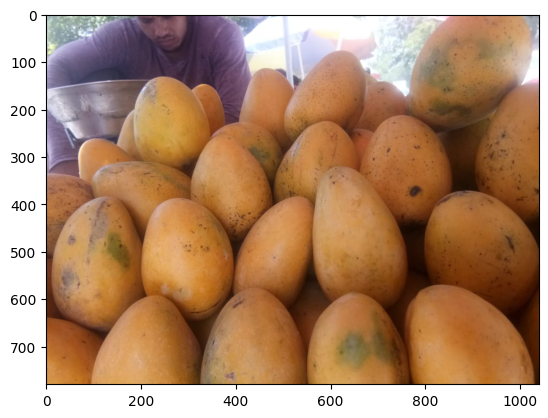

In [76]:
img = cv2.imread("/content/m3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)
plt.imshow(img)

Predict and resize to original resolution

In [77]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

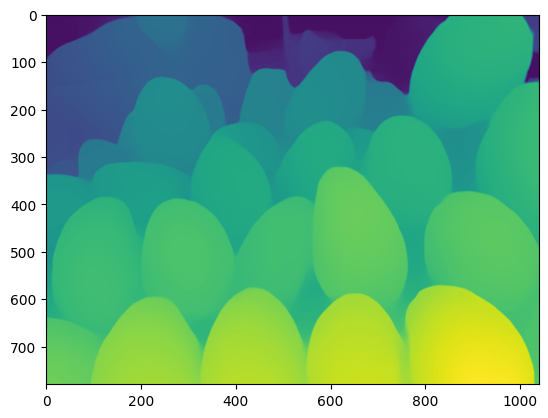

In [78]:
plt.imshow(output)
# plt.show()

In [79]:
depth_8bit = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, thres = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#print(thresholded)
thres.shape

(780, 1040)

In [80]:
mask = thres > 0

In [81]:
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [82]:
output.shape

(780, 1040)

In [83]:
import numpy as np

In [84]:
mask = mask.astype(np.bool)
invalid_value = 0
# Apply the mask to the depth map using element-wise multiplication
masked_depth = np.where(mask, output, invalid_value)



<ipython-input-84-aa121f080240>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)


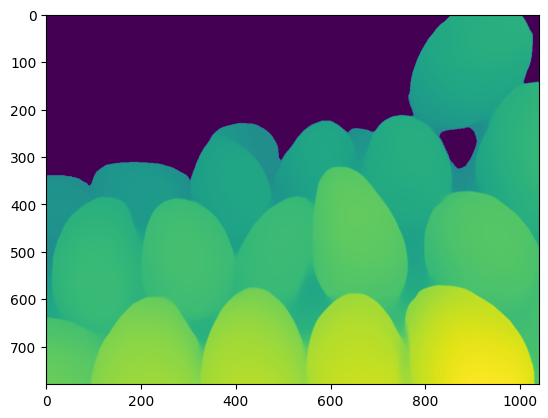

In [85]:
plt.imshow(masked_depth)

In [86]:
from sklearn.cluster import KMeans

In [87]:
depth_values = output.flatten().reshape(-1, 1)

# Perform K-Means clustering to separate the depth values into k clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(depth_values)

# Get the cluster centers
cluster_centers = np.sort(kmeans.cluster_centers_.flatten())

# The threshold is set at the midpoint between the two clusters
threshold = (cluster_centers[0] + 4*cluster_centers[1]) / 5

# Create a binary mask based on the threshold
thresholded = (output >= threshold) * 255

thresholded =  thresholded.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


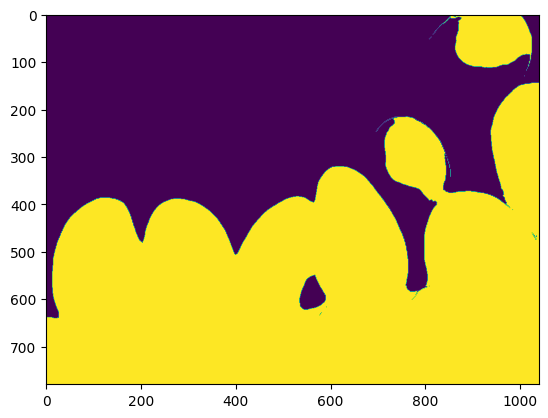

In [88]:
plt.imshow(thresholded)

In [89]:
thresholded

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [90]:
masked_depth2 = np.where(thresholded, output, invalid_value)

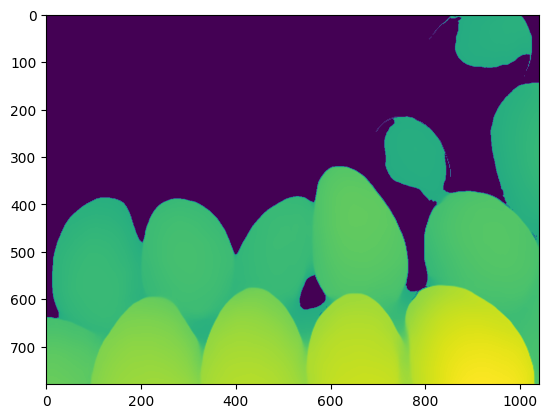

In [91]:
plt.imshow(masked_depth2)

In [92]:
mask2 = output >= threshold

In [93]:
masked_depth3 = np.where(mask2, output, invalid_value)

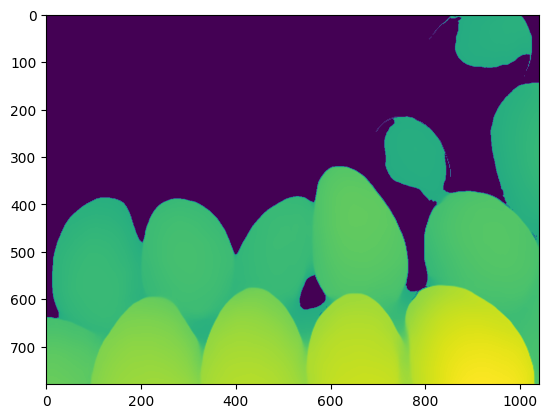

In [94]:
plt.imshow(masked_depth3)

In [95]:
masked_depth3

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [24.996984, 25.002848, 25.01178 , ..., 23.87442 , 23.952574,
        24.006235],
       [24.965605, 24.987694, 25.024351, ..., 24.019928, 23.962374,
        23.932163],
       [24.947578, 24.979008, 25.031614, ..., 24.10758 , 23.968937,
        23.88868 ]], dtype=float32)

In [96]:
mask_rgb = np.stack([thresholded]*3 , axis=-1)
rgb_image = img.astype(np.uint8)
rgb_image = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb = img * mask_rgb

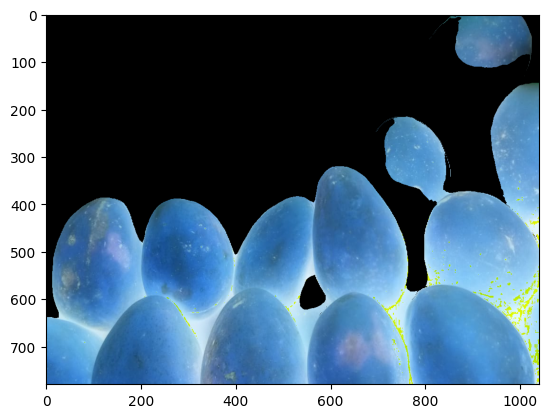

In [97]:
plt.imshow(masked_rgb)

In [98]:
mask2 = (thresholded == 255)

In [99]:
mask_rgb3 = np.stack([mask2]*3 , axis=-1)
rgb_image3 = img.astype(np.uint8)
rgb_image3 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb3 = img * mask_rgb3

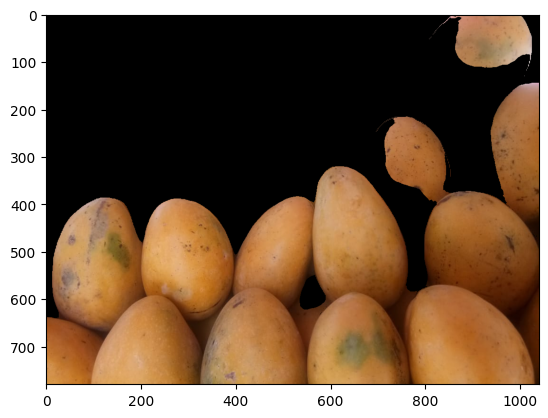

In [100]:
plt.imshow(masked_rgb3)

In [101]:
mask_rgb2 = np.stack([mask]*3 , axis=-1)
#rgb_image2 = img.astype(np.uint8)
#rgb_image2 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb2 = img * mask_rgb2

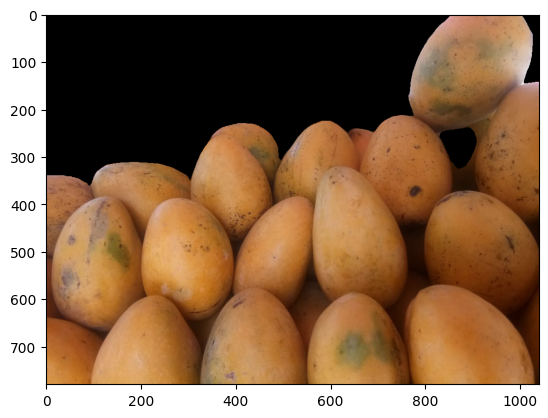

In [102]:
plt.imshow(masked_rgb2)

In [103]:
depth_8bit = cv2.normalize(masked_depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, thres2 = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#print(thresholded)
thres2.shape

(780, 1040)

In [104]:
mask4 = thres2 > 0

In [105]:
mask_rgb4 = np.stack([mask4]*3 , axis=-1)
rgb_image4 = img.astype(np.uint8)
rgb_image4 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb4 = img * mask_rgb4

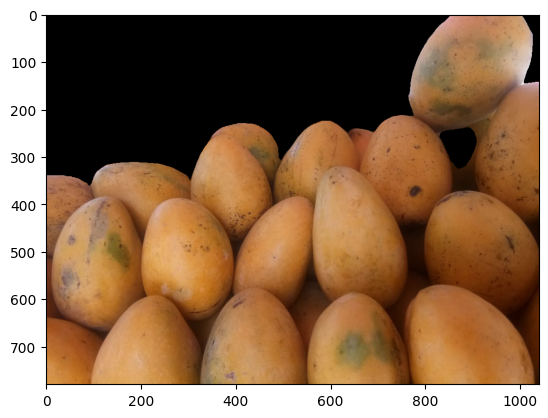

In [106]:
plt.imshow(masked_rgb4)

In [72]:
depth_values = masked_depth3.flatten().reshape(-1, 1)

# Perform K-Means clustering to separate the depth values into k clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(depth_values)

# Get the cluster centers
cluster_centers = np.sort(kmeans.cluster_centers_.flatten())

# The threshold is set at the midpoint between the two clusters
threshold = (cluster_centers[0] + 4*cluster_centers[1]) / 5

# Create a binary mask based on the threshold
thresholded2 = (output >= threshold) * 1

thresholded =  thresholded.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [73]:
mask_rgb4 = np.stack([thresholded2]*3 , axis=-1)
rgb_image4 = img.astype(np.uint8)
rgb_image = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb4 = img * mask_rgb4

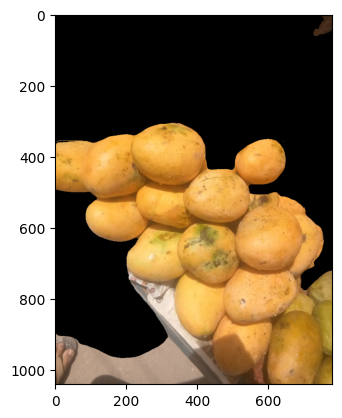

In [74]:
plt.imshow(masked_rgb4)

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [75]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

SyntaxError: ignored

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}